In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.1.0 cuda: True


In [2]:
## Load dataset
data_path = "../gmm_dataset_c20k"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()

NUM_DATASETS, N, D = Data.shape
K = 3 ## number of clusters
SAMPLE_SIZE = 10
NUM_HIDDEN_LOCAL = 32

BATCH_SIZE = 20
NUM_EPOCHS = 300
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
PATH = 'baseline-mlp-%dsamples' % (SAMPLE_SIZE)
DEVICE = torch.device('cuda:0')

Train_Params = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)
Model_Params = (N, K, D)

In [3]:
from local_enc import *
from global_oneshot import *
## if reparameterize continuous variables
Reparameterized = False
# initialization
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
oneshot_eta = Oneshot_eta(K, D, CUDA, DEVICE, Reparameterized)
if CUDA:
    enc_z.cuda().to(DEVICE)
oneshot_eta = Oneshot_eta(K, D, CUDA, DEVICE, Reparameterized)
if CUDA:
    oneshot_eta.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(oneshot_eta.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
models = (oneshot_eta, enc_z)

In [4]:
from os_ep import *
train_baseline(models, EP, optimizer, Data, Model_Params, Train_Params)

epoch: 0\300 (7s),  eubo: -793.605,  elbo: -964.131,  ess: 1.038
epoch: 1\300 (7s),  eubo: -568.102,  elbo: -663.278,  ess: 1.063
epoch: 2\300 (7s),  eubo: -468.269,  elbo: -525.665,  ess: 1.135
epoch: 3\300 (7s),  eubo: -415.057,  elbo: -455.682,  ess: 1.191
epoch: 4\300 (7s),  eubo: -392.664,  elbo: -424.237,  ess: 1.225
epoch: 5\300 (7s),  eubo: -367.954,  elbo: -390.590,  ess: 1.316
epoch: 6\300 (8s),  eubo: -359.538,  elbo: -378.101,  ess: 1.391
epoch: 7\300 (8s),  eubo: -344.504,  elbo: -357.735,  ess: 1.535
epoch: 8\300 (8s),  eubo: -333.205,  elbo: -342.896,  ess: 1.684
epoch: 9\300 (8s),  eubo: -329.915,  elbo: -337.167,  ess: 1.809
epoch: 10\300 (8s),  eubo: -328.269,  elbo: -334.725,  ess: 1.836
epoch: 11\300 (8s),  eubo: -321.620,  elbo: -331.006,  ess: 1.750
epoch: 12\300 (8s),  eubo: -309.772,  elbo: -322.494,  ess: 1.528
epoch: 13\300 (8s),  eubo: -305.241,  elbo: -322.750,  ess: 1.441
epoch: 14\300 (8s),  eubo: -295.425,  elbo: -312.190,  ess: 1.470
epoch: 15\300 (8s), 

In [5]:
torch.save(enc_z.state_dict(), '../weights/enc-z-%s' + PATH)
torch.save(oneshot_eta.state_dict(), '../weights/oneshot-eta-%s' + PATH)

In [6]:
def test(models, objective, Data, Model_Params, Train_Params):
    (NUM_EPOCHS, NUM_DATASETS, S, B, CUDA, device, path) = Train_Params
    SubTrain_Params = (device, S, B) + Model_Params
    ##(N, K, D, mcmc_size) = Model_Params
    indices = torch.randperm(NUM_DATASETS)
    batch_indices = indices[0*B : (0+1)*B]
    obs = Data[batch_indices]
    obs = shuffler(obs).repeat(S, 1, 1, 1)
    if CUDA:
        obs =obs.cuda().to(device)
    loss, metric_step, reused = objective(models, obs, SubTrain_Params)
    return obs, metric_step, reused

In [7]:
BATCH_SIZE_TEST = 50
Train_Params_Test = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, PATH)
obs, metric_step, reused = test(models, EP, Data, Model_Params, Train_Params_Test)
(q_eta, _, q_z, _, _, _) = reused

CPU times: user 2.7 s, sys: 44.9 ms, total: 2.74 s
Wall time: 1.78 s


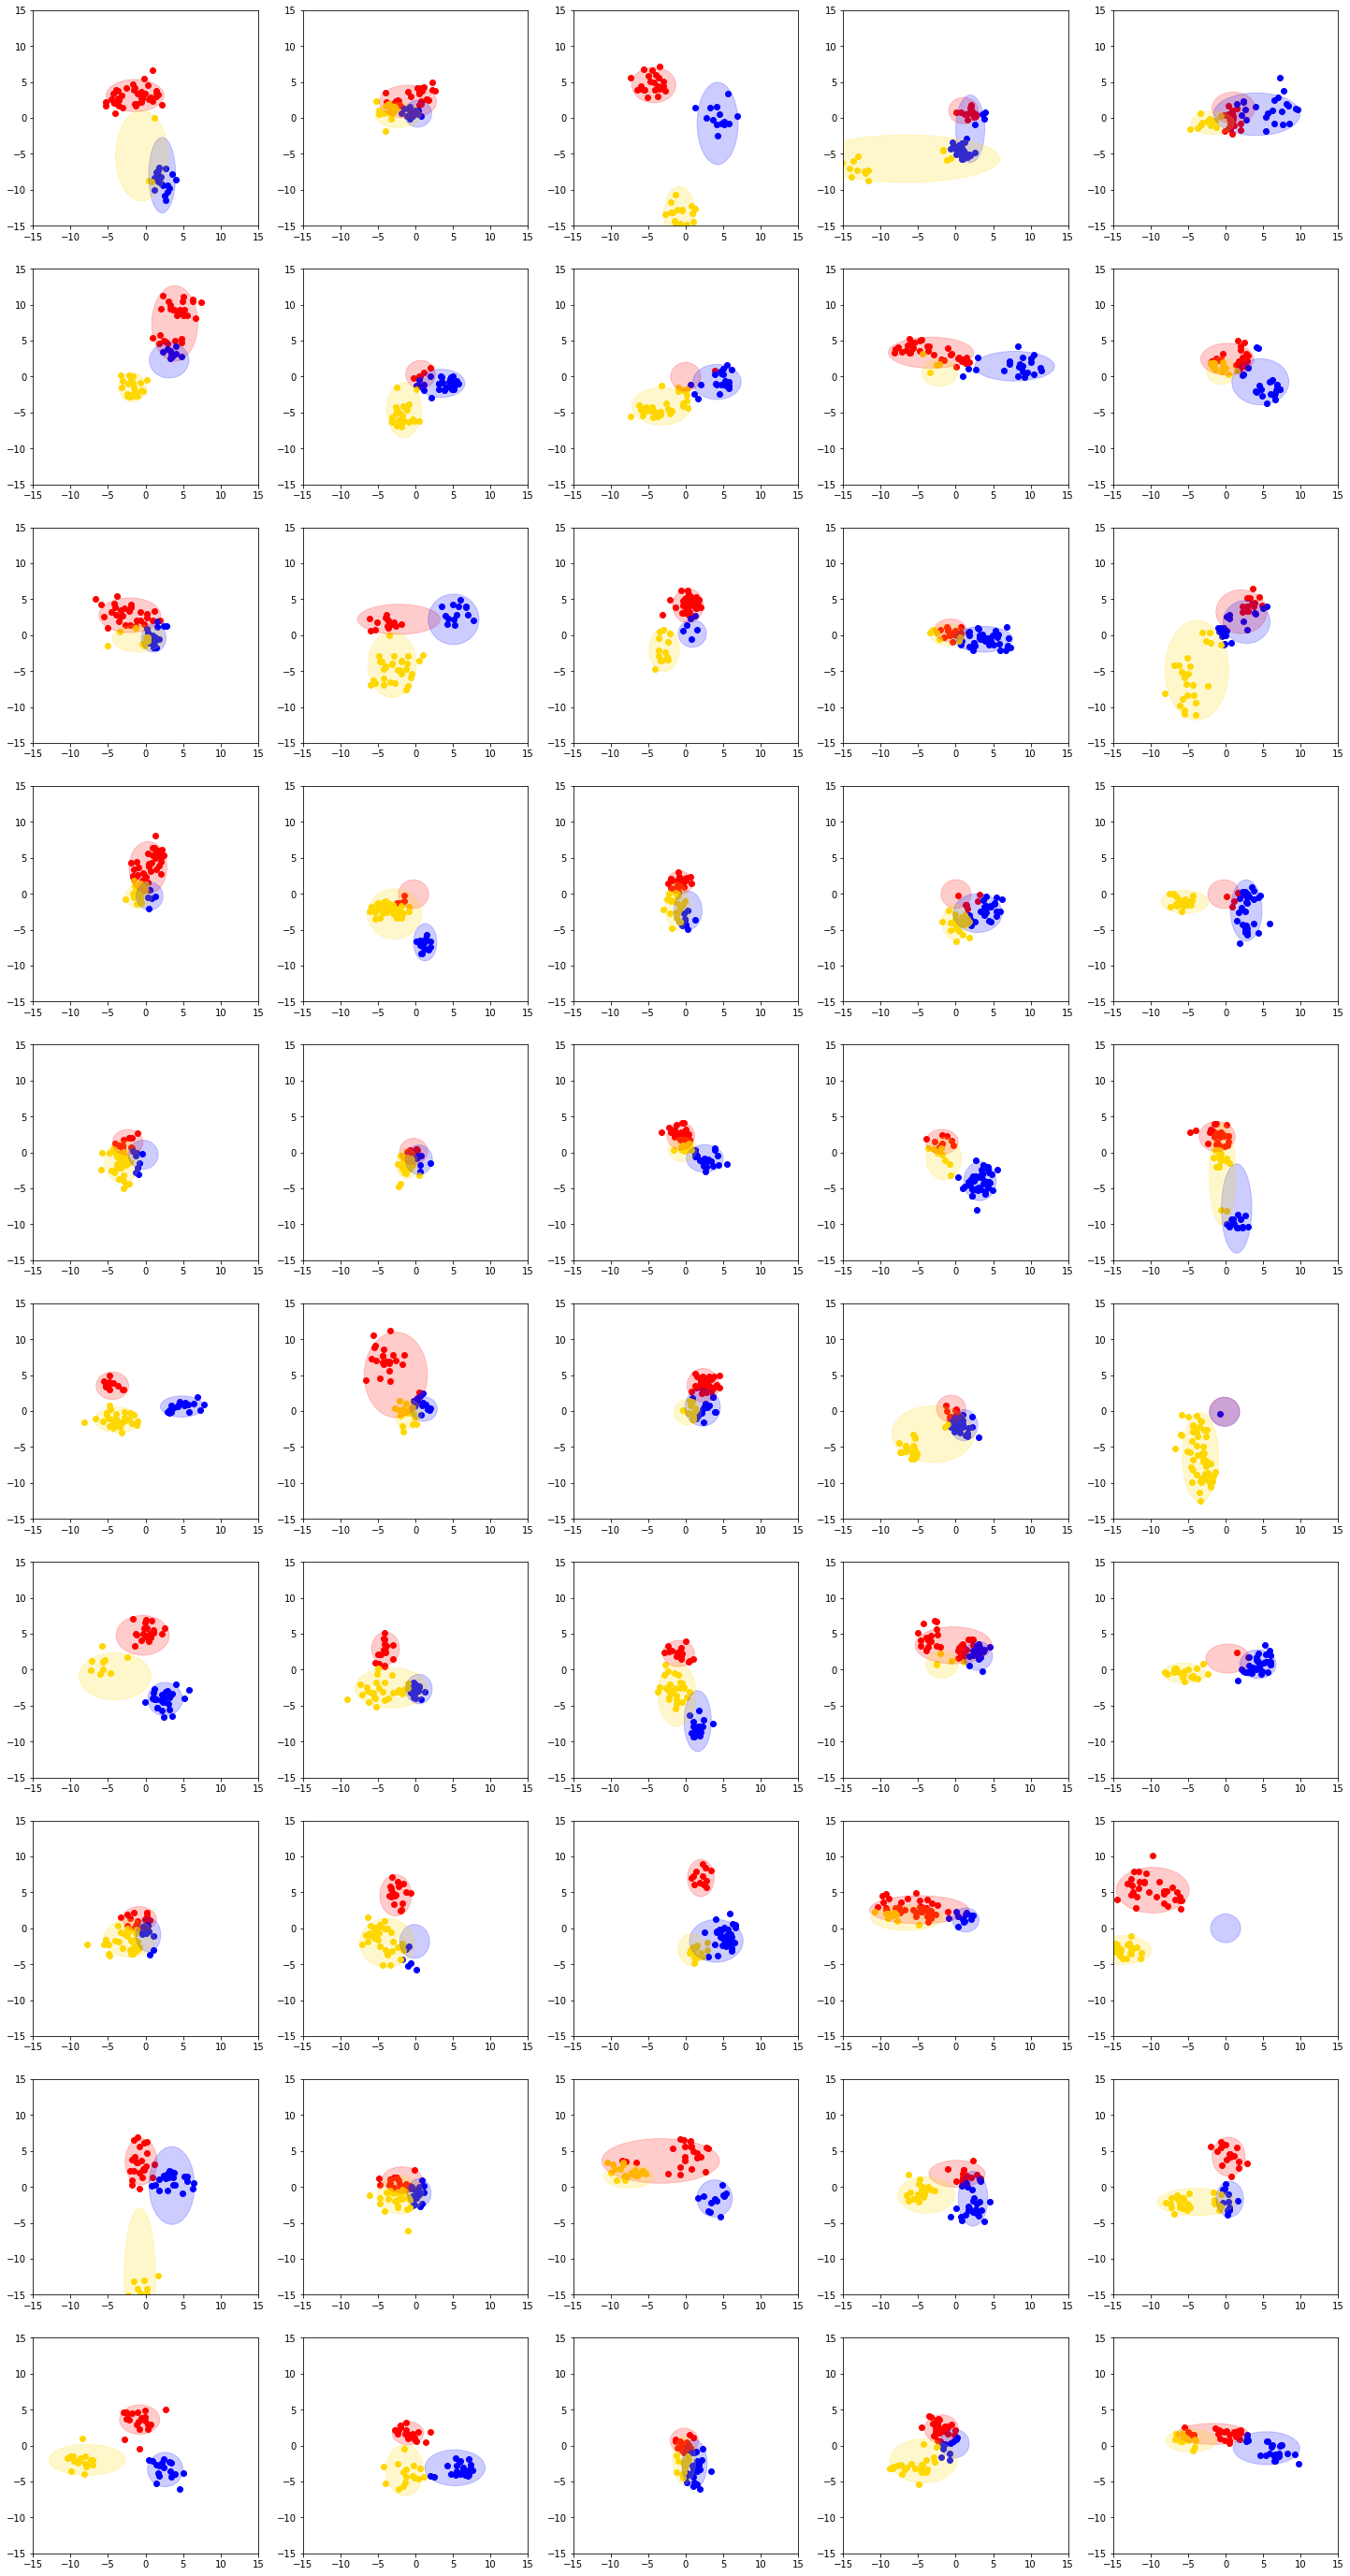

In [8]:
%time plot_samples(obs, q_eta, q_z, PATH)

In [9]:
incremental_gap = symkl_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-2f63a3d893bd>", line 1, in <module>
    incremental_gap = symkl_test.cpu().data.numpy()[1:]
NameError: name 'symkl_test' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hao/anaconda3/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1095, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/hom

NameError: name 'symkl_test' is not defined

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')

In [ ]:
incremental_gap